## 0. dataset Links

Cry: https://www.kaggle.com/datasets/mennaahmed23/baby-crying-sounds-dataset
Non-cry: https://www.kaggle.com/datasets/sanmithasadhish/infant-cry-dataset

## 1. Import Libraries

In [53]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from tqdm.notebook import tqdm
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Navigate to project root
os.chdir(Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd())

print("Libraries loaded")
print(f"Working directory: {Path.cwd()}")

Libraries loaded
Working directory: c:\Users\mkhan\Documents\Projects\Niha\LittleBee


## 2. Load Dataset Metadata

In [54]:
# Dataset paths
CRY_DIR = Path("Dataset/cry")
NONCRY_DIR = Path("Dataset/non-cry")

# Collect all file paths
cry_files = sorted(list(CRY_DIR.glob("*.wav")))
noncry_files = sorted([f for f in NONCRY_DIR.glob("*") if f.suffix in [".wav", ".ogg"]])

print(f"Dataset Summary:")
print(f"Cry samples: {len(cry_files)}")
print(f"Non-cry samples: {len(noncry_files)}")
print(f"Total: {len(cry_files) + len(noncry_files)}")
print(f"Balance ratio: {len(cry_files) / len(noncry_files):.3f}")

# Create dataframe
data = []
for file in cry_files:
    data.append({'filepath': str(file), 'filename': file.name, 'label': 1, 'class': 'cry'})
for file in noncry_files:
    data.append({'filepath': str(file), 'filename': file.name, 'label': 0, 'class': 'non-cry'})

df = pd.DataFrame(data)
print(f"\n✓ Created dataframe with {len(df)} samples")
df.head()

Dataset Summary:
Cry samples: 1450
Non-cry samples: 324
Total: 1774
Balance ratio: 4.475

✓ Created dataframe with 1774 samples


,filepath,filename,label,class
0,Dataset\cry\cry_00000.wav,cry_00000.wav,1,cry
1,Dataset\cry\cry_00001.wav,cry_00001.wav,1,cry
2,Dataset\cry\cry_00002.wav,cry_00002.wav,1,cry
3,Dataset\cry\cry_00003.wav,cry_00003.wav,1,cry
4,Dataset\cry\cry_00004.wav,cry_00004.wav,1,cry


### 2.1 Class Distribution Visualization

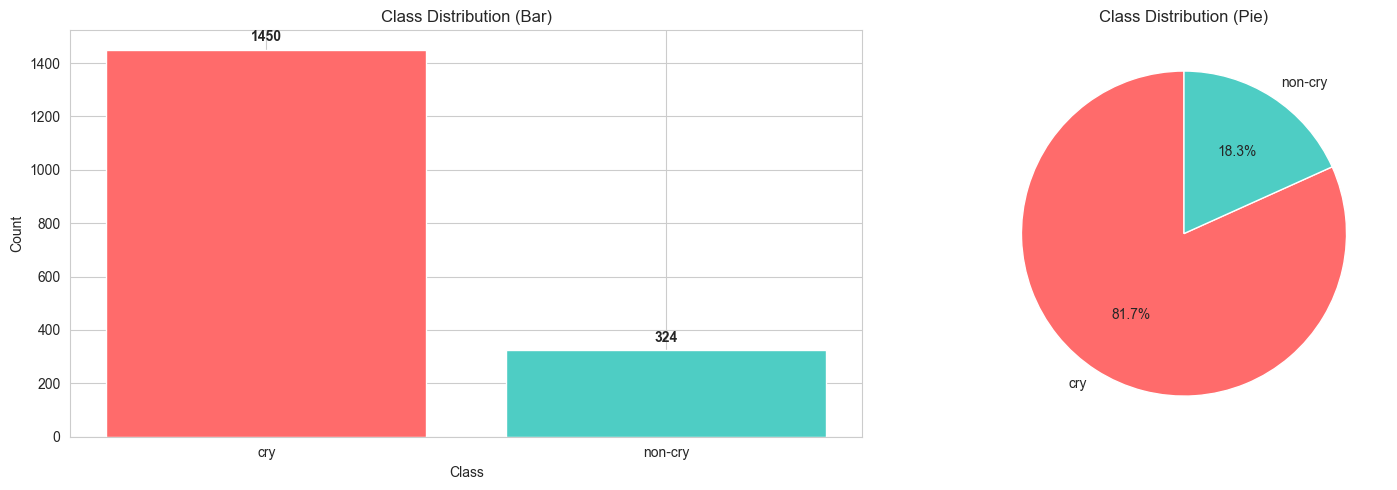

Dataset is slightly imbalanced


In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
class_counts = df['class'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#ff6b6b', '#4ecdc4'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Bar)')
axes[0].set_xlabel('Class')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#ff6b6b', '#4ecdc4']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Pie)')


plt.tight_layout()
plt.show()

print(f"Dataset is {'balanced' if abs(len(cry_files) - len(noncry_files)) < 50 else 'slightly imbalanced'}")

## 3. Audio File Properties Analysis

In [56]:
# Sample a subset for quick analysis
sample_size = 100
sample_df = df.sample(n=sample_size, random_state=42)

# Collect audio properties
audio_props = []
print(f"Analyzing {sample_size} sample files...")

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Loading audio"):
    try:
        audio, sr = sf.read(row['filepath'])
        duration = len(audio) / sr
        audio_props.append({
            'filename': row['filename'],
            'class': row['class'],
            'sample_rate': sr,
            'duration': duration,
            'n_samples': len(audio),
            'channels': 1 if audio.ndim == 1 else audio.shape[1],
            'max_amplitude': np.max(np.abs(audio)),
            'rms': np.sqrt(np.mean(audio**2)),
        })
    except Exception as e:
        print(f"Error loading {row['filename']}: {e}")

props_df = pd.DataFrame(audio_props)
print(f"Loaded {len(props_df)} audio files")

# Display statistics
print("\nAudio Properties Statistics:")
print(props_df.describe())

Analyzing 100 sample files...


Loading audio:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded 100 audio files

Audio Properties Statistics:
        sample_rate    duration      n_samples  channels  max_amplitude  \
count    100.000000  100.000000     100.000000     100.0     100.000000   
mean   20496.000000    6.680190  129368.400000       1.0       0.688355   
std    10353.527872    0.736468   39996.532959       0.0       0.337207   
min    16000.000000    5.000000  112000.000000       1.0       0.036346   
25%    16000.000000    7.000000  112000.000000       1.0       0.380361   
50%    16000.000000    7.000000  112000.000000       1.0       0.828766   
75%    16000.000000    7.000000  112000.000000       1.0       1.000000   
max    44100.000000    7.000000  221120.000000       1.0       1.016757   

              rms  
count  100.000000  
mean     0.108049  
std      0.092402  
min      0.005221  
25%      0.036664  
50%      0.084271  
75%      0.159955  
max      0.528958  


### 3.1 Audio Properties Distribution

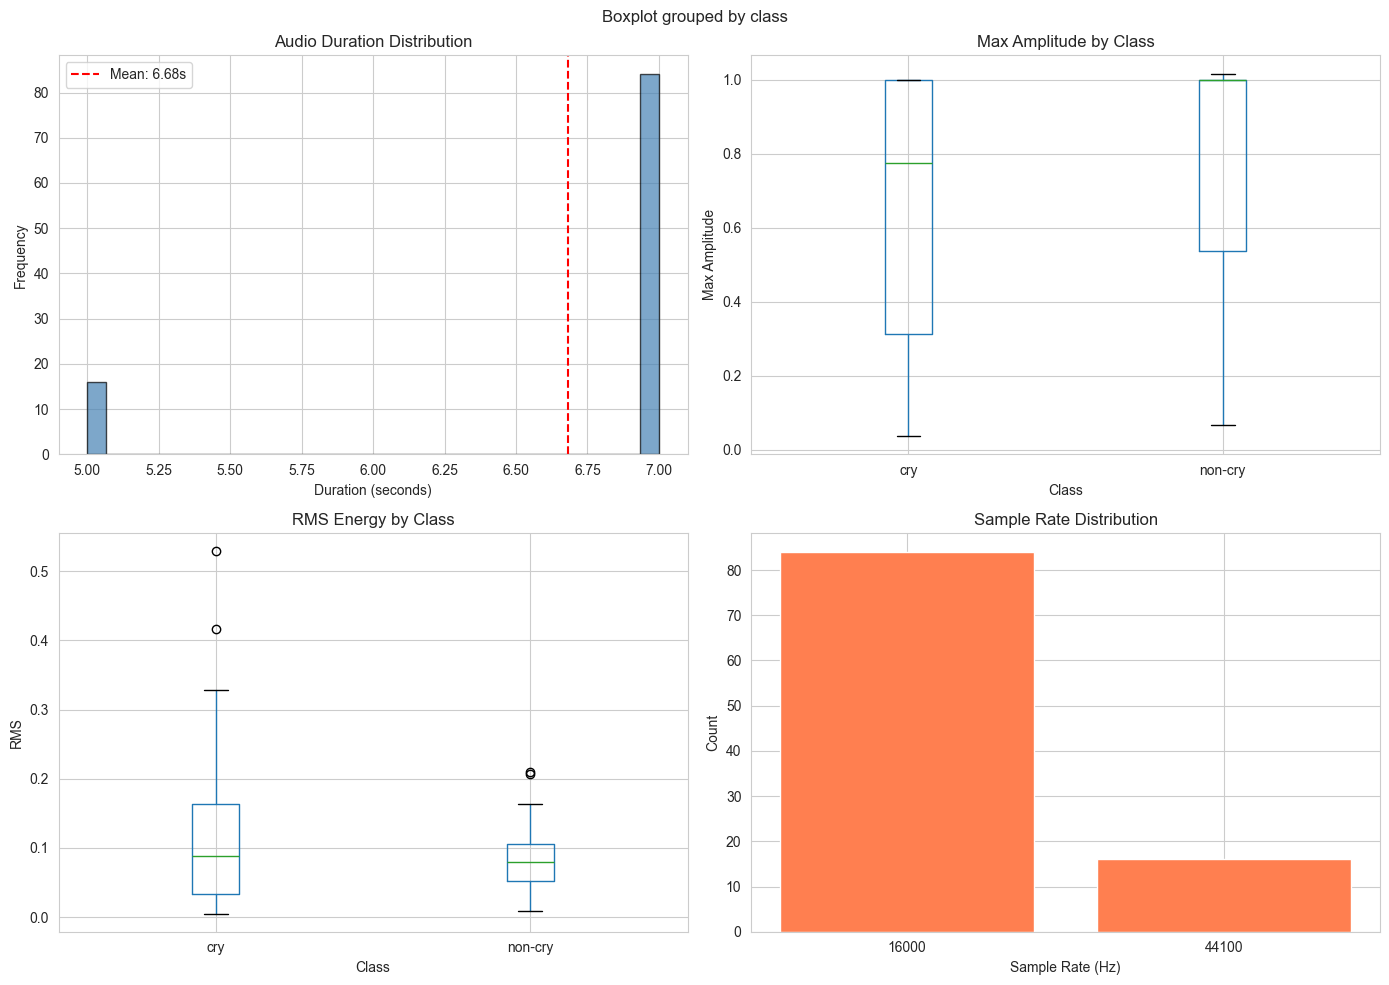

All files have sample rate: [16000 44100]
Mean duration: 6.680s (±0.736s)


In [57]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Duration distribution
axes[0, 0].hist(props_df['duration'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Duration (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Audio Duration Distribution')
axes[0, 0].axvline(props_df['duration'].mean(), color='red', linestyle='--', label=f'Mean: {props_df["duration"].mean():.2f}s')
axes[0, 0].legend()

# Max amplitude by class
props_df.boxplot(column='max_amplitude', by='class', ax=axes[0, 1])
axes[0, 1].set_title('Max Amplitude by Class')
axes[0, 1].set_ylabel('Max Amplitude')
axes[0, 1].set_xlabel('Class')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# RMS by class
props_df.boxplot(column='rms', by='class', ax=axes[1, 0])
axes[1, 0].set_title('RMS Energy by Class')
axes[1, 0].set_ylabel('RMS')
axes[1, 0].set_xlabel('Class')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Sample rate check
sr_counts = props_df['sample_rate'].value_counts()
axes[1, 1].bar(sr_counts.index.astype(str), sr_counts.values, color='coral')
axes[1, 1].set_xlabel('Sample Rate (Hz)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Sample Rate Distribution')

plt.tight_layout()
plt.show()

print(f"All files have sample rate: {props_df['sample_rate'].unique()}")
print(f"Mean duration: {props_df['duration'].mean():.3f}s (±{props_df['duration'].std():.3f}s)")

## 4. Waveform Analysis

Visualize and compare raw audio waveforms between cry and non-cry samples.

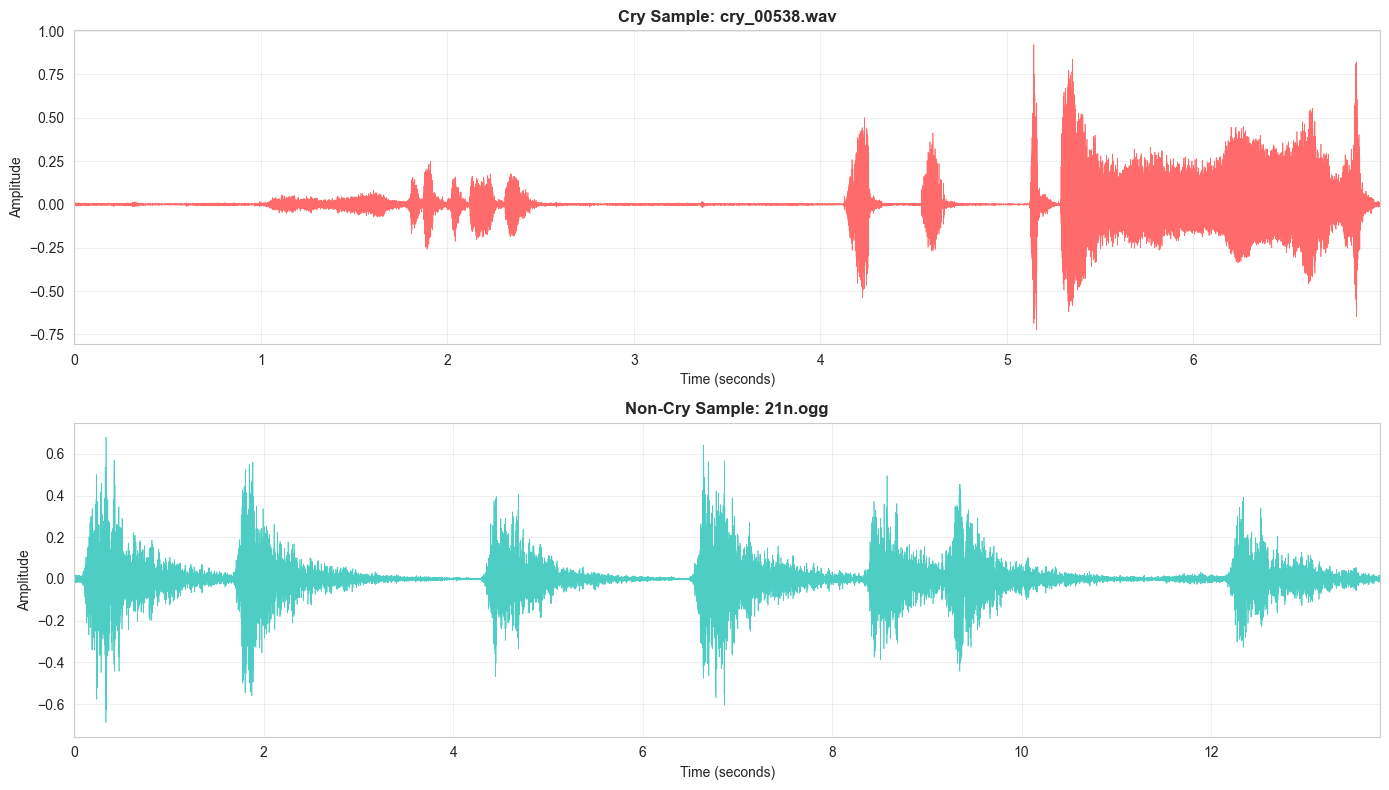

Cry Sample:


Cry sample - Max amplitude: 0.922, RMS: 0.079
Non-Cry Sample:


Non-cry sample - Max amplitude: 0.688, RMS: 0.076


In [58]:
# Select random samples from each class
cry_sample = df[df['class'] == 'cry'].sample(1, random_state=42).iloc[0]
noncry_sample = df[df['class'] == 'non-cry'].sample(1, random_state=42).iloc[0]

# Load audio
cry_audio, sr = sf.read(cry_sample['filepath'])
noncry_audio, _ = sf.read(noncry_sample['filepath'])

# Create time arrays
cry_time = np.arange(len(cry_audio)) / sr
noncry_time = np.arange(len(noncry_audio)) / sr

# Plot waveforms
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Cry waveform
axes[0].plot(cry_time, cry_audio, color='#ff6b6b', linewidth=0.5)
axes[0].set_title(f'Cry Sample: {cry_sample["filename"]}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, max(cry_time))

# Non-cry waveform
axes[1].plot(noncry_time, noncry_audio, color='#4ecdc4', linewidth=0.5)
axes[1].set_title(f'Non-Cry Sample: {noncry_sample["filename"]}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, max(noncry_time))

plt.tight_layout()
plt.show()



print("Cry Sample:")
display(Audio(cry_audio, rate=sr))

print(f"Cry sample - Max amplitude: {np.max(np.abs(cry_audio)):.3f}, RMS: {np.sqrt(np.mean(cry_audio**2)):.3f}")

print("Non-Cry Sample:")
display(Audio(noncry_audio, rate=sr))
print(f"Non-cry sample - Max amplitude: {np.max(np.abs(noncry_audio)):.3f}, RMS: {np.sqrt(np.mean(noncry_audio**2)):.3f}")

## 5. Spectrogram Analysis

Spectrograms show the frequency content of audio over time - crucial for audio deep learning.

  - Cry samples often show harmonic structures and high-frequency components
  - Non-cry samples show more broadband/noise-like patterns


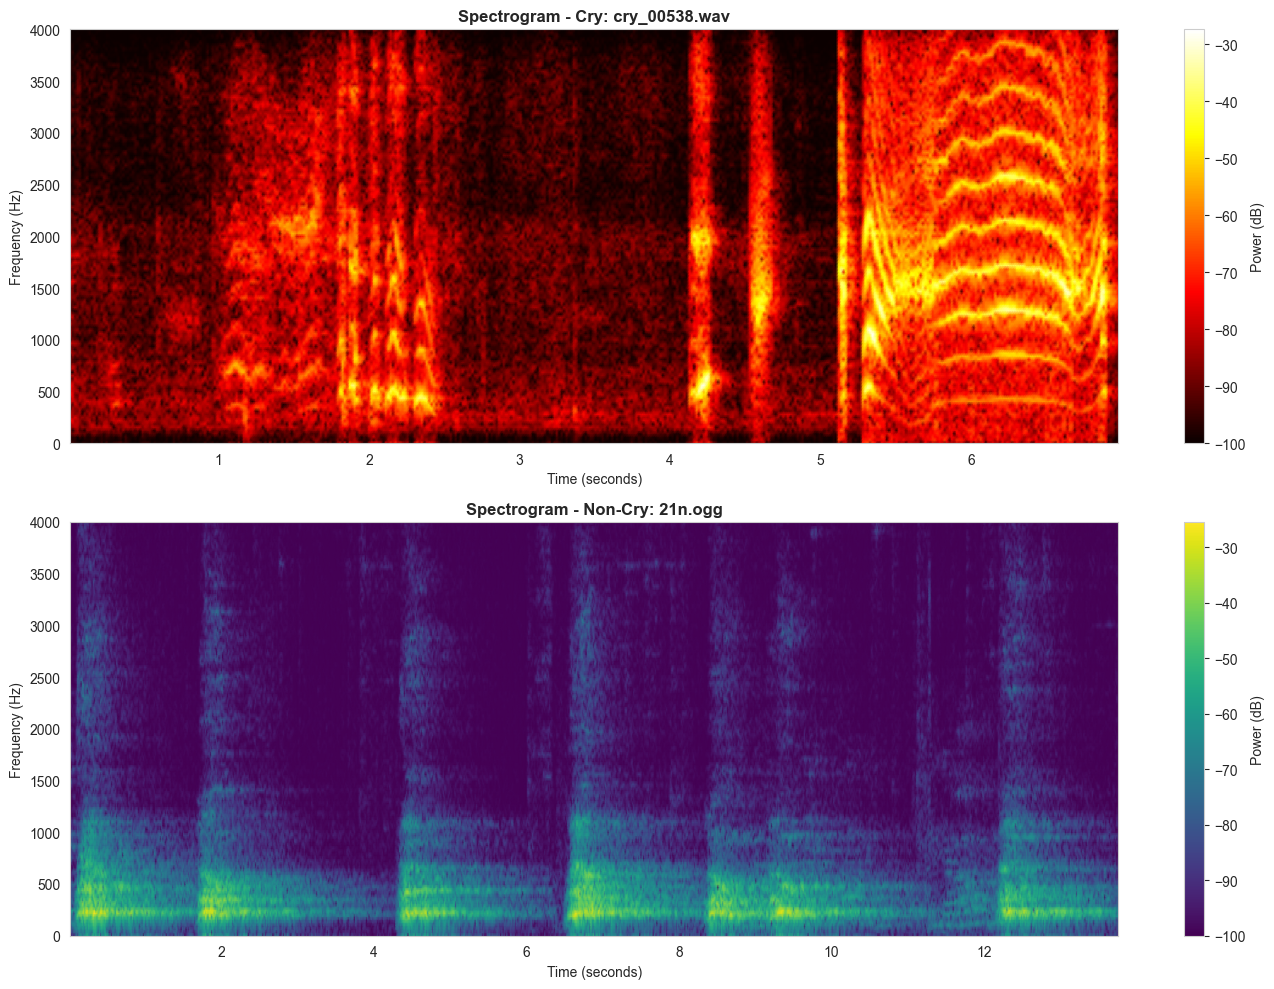

Spectrograms show frequency content over time


In [59]:
from scipy import signal

def plot_spectrogram(audio, sr, title, ax, cmap='viridis'):
    """Plot spectrogram of audio signal"""
    # Compute spectrogram
    f, t, Sxx = signal.spectrogram(audio, sr, nperseg=512, noverlap=256)
    
    # Convert to dB scale
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    
    # Plot
    im = ax.pcolormesh(t, f, Sxx_db, shading='gouraud', cmap=cmap)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (seconds)')
    ax.set_title(title, fontweight='bold')
    ax.set_ylim(0, 4000)  # Focus on 0-4kHz range
    plt.colorbar(im, ax=ax, label='Power (dB)')
    return im

# Plot spectrograms
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_spectrogram(cry_audio, sr, f'Spectrogram - Cry: {cry_sample["filename"]}', 
                axes[0], cmap='hot')
print("  - Cry samples often show harmonic structures and high-frequency components")

plot_spectrogram(noncry_audio, sr, f'Spectrogram - Non-Cry: {noncry_sample["filename"]}', 
                axes[1], cmap='viridis')
print("  - Non-cry samples show more broadband/noise-like patterns")

plt.tight_layout()
plt.show()

print("Spectrograms show frequency content over time")



## 6. MFCC Features

Mel-Frequency Cepstral Coefficients (MFCCs) are widely used for audio classification tasks. They capture the timbral characteristics of audio signals.

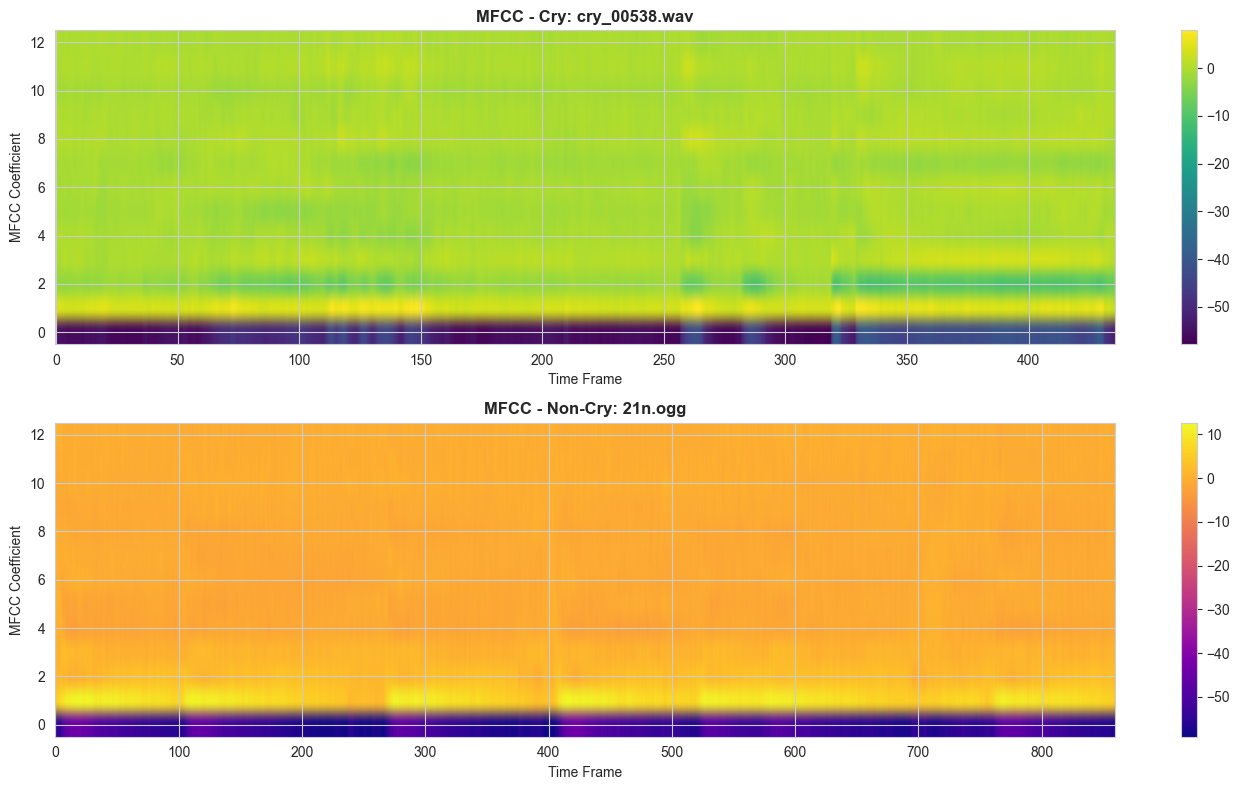

MFCC shape for cry: (13, 436)
MFCC shape for non-cry: (13, 860)


In [60]:
from scipy.fftpack import dct

def extract_mfcc(audio, sr, n_mfcc=13, n_fft=512, hop_length=256, n_mels=40):
    """Extract MFCC features from audio signal"""
    # Compute mel spectrogram
    f, t, Sxx = signal.spectrogram(audio, sr, nperseg=n_fft, noverlap=n_fft-hop_length)
    
    # Create mel filterbank
    mel_basis = np.zeros((n_mels, len(f)))
    mel_freqs = np.linspace(0, 2595 * np.log10(1 + sr/2 / 700), n_mels + 2)
    hz_freqs = 700 * (10**(mel_freqs / 2595) - 1)
    
    for i in range(n_mels):
        left = hz_freqs[i]
        center = hz_freqs[i+1]
        right = hz_freqs[i+2]
        
        for j, freq in enumerate(f):
            if left <= freq <= center:
                mel_basis[i, j] = (freq - left) / (center - left)
            elif center <= freq <= right:
                mel_basis[i, j] = (right - freq) / (right - center)
    
    # Apply mel filterbank
    mel_spec = np.dot(mel_basis, Sxx)
    
    # Convert to dB
    log_mel_spec = np.log10(mel_spec + 1e-10)
    
    # Apply DCT
    mfcc = dct(log_mel_spec, axis=0, norm='ortho')[:n_mfcc]
    
    return mfcc

# Extract MFCCs from sample audios
cry_mfcc = extract_mfcc(cry_audio, sr)
noncry_mfcc = extract_mfcc(noncry_audio, sr)

# Plot MFCCs
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Cry MFCC
im1 = axes[0].imshow(cry_mfcc, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title(f'MFCC - Cry: {cry_sample["filename"]}', fontweight='bold')
axes[0].set_ylabel('MFCC Coefficient')
axes[0].set_xlabel('Time Frame')
plt.colorbar(im1, ax=axes[0])

# Non-cry MFCC
im2 = axes[1].imshow(noncry_mfcc, aspect='auto', origin='lower', cmap='plasma')
axes[1].set_title(f'MFCC - Non-Cry: {noncry_sample["filename"]}', fontweight='bold')
axes[1].set_ylabel('MFCC Coefficient')
axes[1].set_xlabel('Time Frame')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"MFCC shape for cry: {cry_mfcc.shape}")
print(f"MFCC shape for non-cry: {noncry_mfcc.shape}")

## 7. Spectral Features

Spectral features provide insights into the frequency distribution and characteristics of audio signals.

In [61]:
def extract_spectral_features(audio, sr):
    """Extract spectral features from audio signal"""
    # Compute FFT
    fft = np.fft.fft(audio)
    magnitude = np.abs(fft)[:len(audio)//2]
    freqs = np.fft.fftfreq(len(audio), 1/sr)[:len(audio)//2]
    
    # Normalize magnitude
    magnitude_norm = magnitude / (np.sum(magnitude) + 1e-10)
    
    # Spectral Centroid
    spectral_centroid = np.sum(freqs * magnitude_norm)
    
    # Spectral Rolloff (85% of energy)
    cumsum = np.cumsum(magnitude_norm)
    rolloff_idx = np.where(cumsum >= 0.85)[0]
    spectral_rolloff = freqs[rolloff_idx[0]] if len(rolloff_idx) > 0 else freqs[-1]
    
    # Spectral Bandwidth
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid)**2) * magnitude_norm))
    
    # Zero Crossing Rate
    zero_crossings = np.sum(np.abs(np.diff(np.sign(audio)))) / (2 * len(audio))
    
    # RMS Energy
    rms_energy = np.sqrt(np.mean(audio**2))
    
    return {
        'spectral_centroid': spectral_centroid,
        'spectral_rolloff': spectral_rolloff,
        'spectral_bandwidth': spectral_bandwidth,
        'zero_crossing_rate': zero_crossings,
        'rms_energy': rms_energy
    }

# Extract features for multiple samples
print("Extracting spectral features from dataset samples...")
n_samples = 200  # Sample size for analysis

cry_features = []
noncry_features = []

for i in tqdm(range(min(n_samples, len(cry_files))), desc="Processing Cry"):
    audio, _ = sf.read(cry_files[i])
    features = extract_spectral_features(audio, sr)
    features['class'] = 'cry'
    cry_features.append(features)

for i in tqdm(range(min(n_samples, len(noncry_files))), desc="Processing Non-Cry"):
    audio, _ = sf.read(noncry_files[i])
    features = extract_spectral_features(audio, sr)
    features['class'] = 'non-cry'
    noncry_features.append(features)

# Create DataFrame
spectral_df = pd.DataFrame(cry_features + noncry_features)
print(f"\nExtracted spectral features from {len(spectral_df)} samples")
spectral_df.head()

Extracting spectral features from dataset samples...


Processing Cry:   0%|          | 0/200 [00:00<?, ?it/s]

Processing Non-Cry:   0%|          | 0/200 [00:00<?, ?it/s]


Extracted spectral features from 400 samples


,spectral_centroid,spectral_rolloff,spectral_bandwidth,zero_crossing_rate,rms_energy,class
0,1615.726145,2916.142857,945.355925,0.146357,0.083829,cry
1,1386.264412,2851.714286,992.887663,0.073321,0.038812,cry
2,1903.720185,3205.714286,969.328229,0.183750,0.120466,cry
3,1390.917225,2245.285714,839.636424,0.109545,0.129388,cry
4,1032.906842,1923.571429,823.211441,0.180353,0.009629,cry


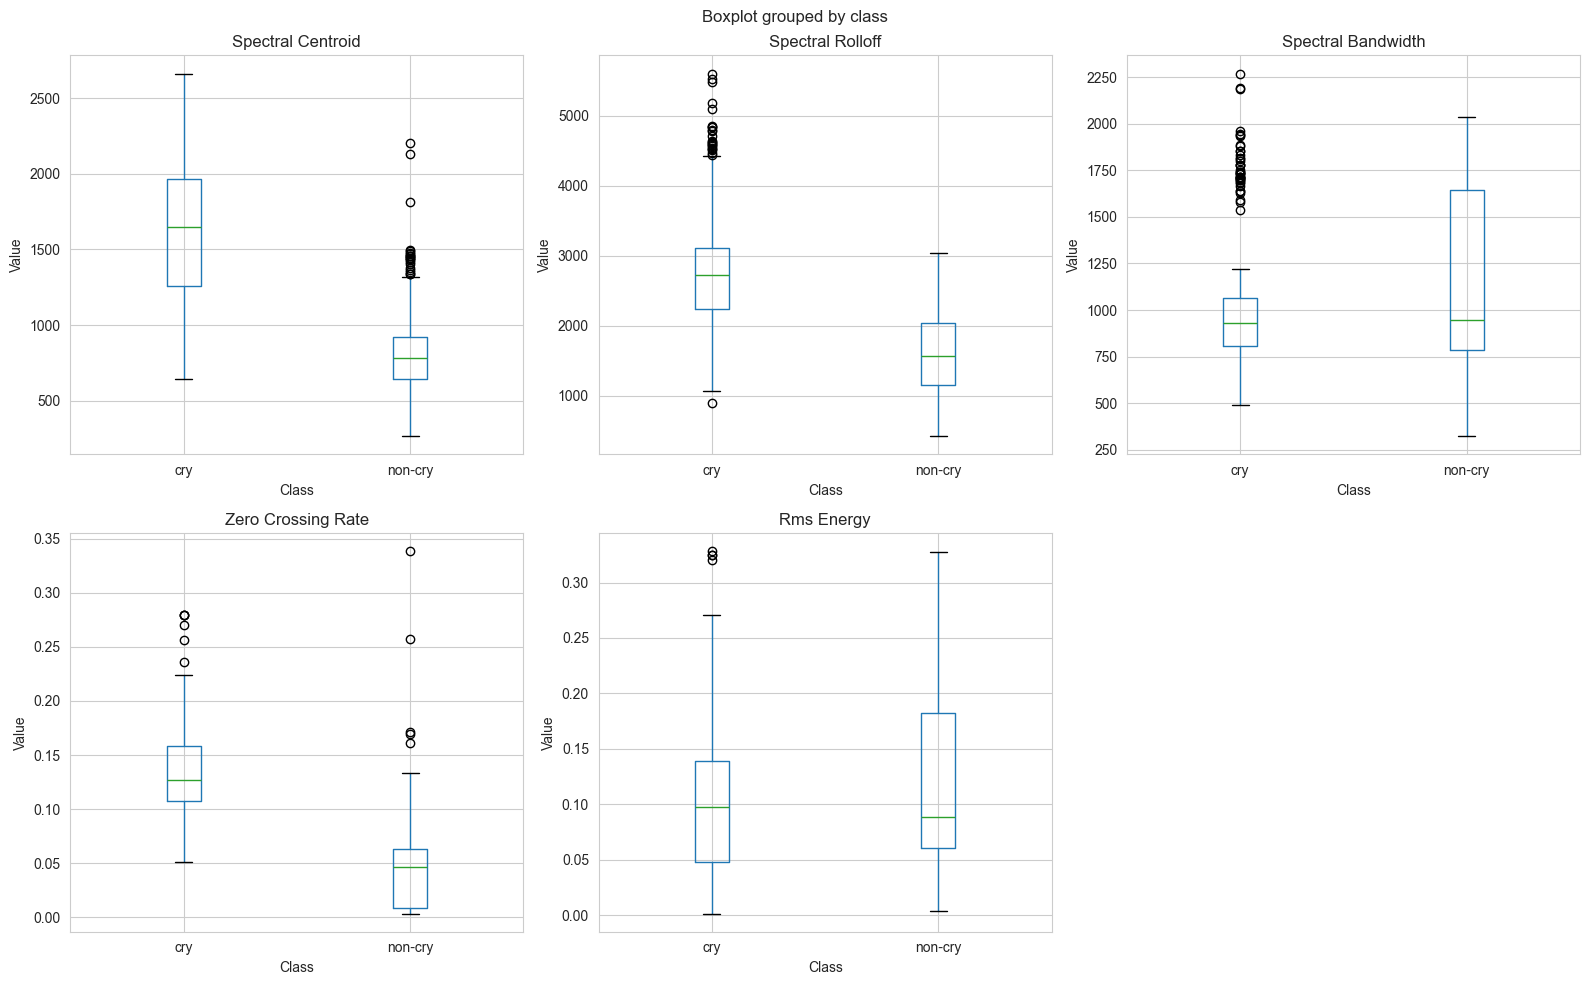


SPECTRAL FEATURES SUMMARY

SPECTRAL_CENTROID:
                mean         std         min          max
class                                                    
cry      1662.295070  492.331759  642.783289  2662.508582
non-cry   838.101832  307.685448  265.047724  2203.568367

SPECTRAL_ROLLOFF:
                mean         std         min          max
class                                                    
cry      2861.495000  958.826412  888.285714  5603.857143
non-cry  1614.955951  628.701822  420.312953  3032.961451

SPECTRAL_BANDWIDTH:
                mean         std         min          max
class                                                    
cry      1059.596574  395.079574  489.210741  2268.605782
non-cry  1135.713253  449.610257  323.672265  2036.415240

ZERO_CROSSING_RATE:
             mean       std       min       max
class                                          
cry      0.135932  0.043504  0.051009  0.279054
non-cry  0.050009  0.045956  0.003598  0.338453

RMS

In [62]:
# Visualize spectral features distribution
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Spectral Features Comparison: Cry vs Non-Cry', fontsize=16, fontweight='bold')

features = ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth', 
            'zero_crossing_rate', 'rms_energy']

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Box plot
    spectral_df.boxplot(column=feature, by='class', ax=ax)
    ax.set_title(f'{feature.replace("_", " ").title()}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Value')
    plt.sca(ax)
    plt.xticks(rotation=0)

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*60)
print("SPECTRAL FEATURES SUMMARY")
print("="*60)
for feature in features:
    print(f"\n{feature.upper()}:")
    print(spectral_df.groupby('class')[feature].describe()[['mean', 'std', 'min', 'max']])

## 8. Feature Correlation Analysis

Understanding correlations between features helps identify redundant features and relationships.

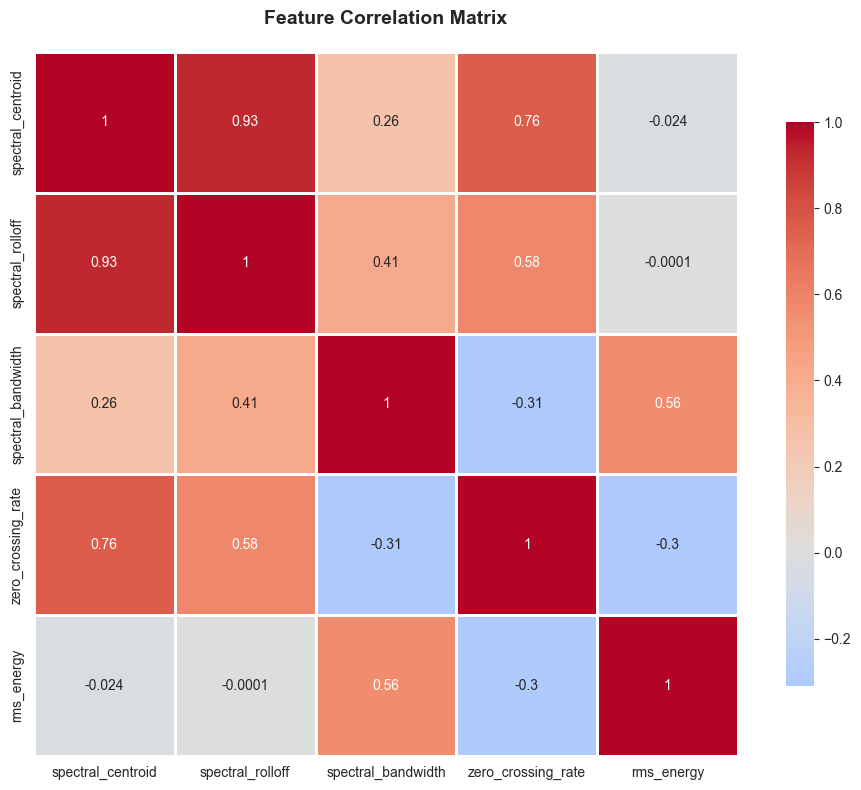

Correlation analysis complete

Highly correlated features (|r| > 0.7):
  - spectral_centroid ↔ spectral_rolloff: 0.931
  - spectral_centroid ↔ zero_crossing_rate: 0.757


In [63]:
# Compute correlation matrix
feature_cols = ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth', 
                'zero_crossing_rate', 'rms_energy']
corr_matrix = spectral_df[feature_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Correlation analysis complete")
print("\nHighly correlated features (|r| > 0.7):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"  - {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

## 9. Data Quality Checks

Verify data integrity, detect anomalies, and ensure dataset is ready for model training.

In [64]:
print("="*60)
print("DATA QUALITY CHECKS")
print("="*60)

# Check for issues
issues = {
    'silent_files': [],
    'clipped_files': [],
    'duration_mismatch': [],
    'nan_inf_values': []
}

# Sample check on subset
check_sample = df.sample(min(200, len(df)), random_state=42)

for _, row in tqdm(check_sample.iterrows(), total=len(check_sample), desc="Quality checks"):
    try:
        audio, sr = sf.read(row['filepath'])
        
        # Check for silence
        if np.allclose(audio, 0.0):
            issues['silent_files'].append(row['filename'])
        
        # Check for clipping
        if np.max(np.abs(audio)) >= 0.999:
            issues['clipped_files'].append(row['filename'])
        
        # Check duration (should be ~7 seconds)
        duration = len(audio) / sr
        if abs(duration - 7.0) > 0.1:
            issues['duration_mismatch'].append((row['filename'], duration))
        
        # Check for NaN/Inf
        if np.isnan(audio).any() or np.isinf(audio).any():
            issues['nan_inf_values'].append(row['filename'])
            
    except Exception as e:
        print(f"Error checking {row['filename']}: {e}")

# Report issues
print(f"\nQuality Check Results:")
print(f"Silent files: {len(issues['silent_files'])}")
print(f"Clipped files: {len(issues['clipped_files'])}")
print(f"Duration mismatches: {len(issues['duration_mismatch'])}")
print(f"NaN/Inf values: {len(issues['nan_inf_values'])}")

if len(issues['duration_mismatch']) > 0:
    print(f"\n Duration mismatches found:")
    for fname, dur in issues['duration_mismatch'][:5]:
        print(f"     {fname}: {dur:.2f}s")

# Check class balance
print(f"\nClass balance: {len(cry_files)}/{len(noncry_files)} = {len(cry_files)/len(noncry_files):.3f}")
print("Dataset quality checks complete")

DATA QUALITY CHECKS


Quality checks:   0%|          | 0/200 [00:00<?, ?it/s]


Quality Check Results:
Silent files: 0
Clipped files: 68
Duration mismatches: 45
NaN/Inf values: 0

 Duration mismatches found:
     205n.wav: 5.00s
     116n.wav: 5.00s
     138n.wav: 5.00s
     201n.wav: 5.00s
     157n.wav: 5.00s

Class balance: 1450/324 = 4.475
Dataset quality checks complete


## 10. Audio Standardization with FFmpeg

**Purpose:** Convert all non-cry audio files to standardized format (7s, 16kHz, mono WAV) using FFmpeg.

This section ensures consistent audio properties across the dataset by:
- Converting to mono (single channel)
- Resampling to 16kHz sample rate
- Padding or trimming to exactly 7 seconds duration
- Using PCM 16-bit encoding

In [65]:
import subprocess
import imageio_ffmpeg

# Configuration
TARGET_SR = 16000  # 16kHz sample rate
TARGET_DUR = 7.0   # 7 seconds duration
FFMPEG_BIN = imageio_ffmpeg.get_ffmpeg_exe()  # Get bundled FFmpeg binary
NONCRY_STD_DIR = Path("Dataset/non-cry_standardized")

def count_audio_files(directory):
    """Count audio files in directory"""
    audio_exts = {'.wav', '.mp3', '.ogg', '.flac', '.m4a', '.aac', '.3gp'}
    files = [f for f in directory.glob("*") if f.suffix.lower() in audio_exts]
    return len(files), files

def standardize_audio_ffmpeg(src_path, dst_path, sr=TARGET_SR, duration=TARGET_DUR, ffmpeg_bin=FFMPEG_BIN):
    """Convert audio to 7s mono WAV at target sample rate using ffmpeg"""
    filter_expr = f"apad,atrim=0:{duration}"
    cmd = [
        ffmpeg_bin, "-y", "-loglevel", "error",
        "-i", str(src_path),
        "-ac", "1",
        "-ar", str(sr),
        "-filter_complex", filter_expr,
        "-c:a", "pcm_s16le",
        str(dst_path),
    ]
    proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    if proc.returncode != 0:
        raise RuntimeError(f"ffmpeg failed: {proc.stdout}")

# Create output directory
NONCRY_STD_DIR.mkdir(parents=True, exist_ok=True)

# Count raw non-cry files
noncry_count, noncry_files_raw = count_audio_files(NONCRY_DIR)

# Standardize all non-cry files
print(f"Standardizing {noncry_count} non-cry files...")
print(f"Source: {NONCRY_DIR}")
print(f"Destination: {NONCRY_STD_DIR}")
print(f"Target: {TARGET_SR}Hz, {TARGET_DUR}s, mono\n")

conversion_errors = []
for idx, src_file in enumerate(tqdm(noncry_files_raw, desc="Converting")):
    dst_file = NONCRY_STD_DIR / f"noncry_{idx:05d}.wav"
    try:
        standardize_audio_ffmpeg(src_file, dst_file)
    except Exception as e:
        conversion_errors.append((src_file.name, str(e)))
        print(f"Failed to convert {src_file.name}: {e}")

# Count standardized files
std_count, _ = count_audio_files(NONCRY_STD_DIR)
print(f"\nStandardized {std_count} non-cry files to {NONCRY_STD_DIR}")
print(f"Successful: {std_count}/{noncry_count}")
print(f"Errors: {len(conversion_errors)}")

if conversion_errors:
    print(f"\nConversion errors:")
    for fname, err in conversion_errors[:5]:
        print(f"     {fname}: {err}")

Standardizing 324 non-cry files...
Source: Dataset\non-cry
Destination: Dataset\non-cry_standardized
Target: 16000Hz, 7.0s, mono



Converting:   0%|          | 0/324 [00:00<?, ?it/s]


Standardized 1424 non-cry files to Dataset\non-cry_standardized
Successful: 1424/324
Errors: 0


### 10.1 Verify Standardization Results

Check that all standardized files meet the target specifications (7s duration, 16kHz sample rate, mono).

In [66]:
# Verify standardized files
print("🔍 Verifying standardized audio files...\n")

std_files = sorted(NONCRY_STD_DIR.glob("*.wav"))
sample_check = std_files[:min(10, len(std_files))]

verification_results = {
    'correct_sr': 0,
    'correct_duration': 0,
    'correct_channels': 0,
    'total_checked': 0
}

for fpath in sample_check:
    audio, sr = sf.read(fpath)
    duration = len(audio) / sr
    channels = 1 if audio.ndim == 1 else audio.shape[1]
    
    if sr == TARGET_SR:
        verification_results['correct_sr'] += 1
    if abs(duration - TARGET_DUR) < 0.01:
        verification_results['correct_duration'] += 1
    if channels == 1:
        verification_results['correct_channels'] += 1
    
    verification_results['total_checked'] += 1

print(f"Verification Results (sampled {len(sample_check)} files):")
print(f"Sample rate = {TARGET_SR}Hz: {verification_results['correct_sr']}/{verification_results['total_checked']}")
print(f"Duration = {TARGET_DUR}s: {verification_results['correct_duration']}/{verification_results['total_checked']}")
print(f"Channels = 1 (mono): {verification_results['correct_channels']}/{verification_results['total_checked']}")

# Check if all verified
all_correct = (verification_results['correct_sr'] == verification_results['total_checked'] and
               verification_results['correct_duration'] == verification_results['total_checked'] and
               verification_results['correct_channels'] == verification_results['total_checked'])

if all_correct:
    print(f"\nAll standardized files meet target specifications!")
else:
    print(f"\nSome files may not meet specifications. Check conversion process.")

# Update file counts
noncry_files = sorted(NONCRY_STD_DIR.glob("*.wav"))
print(f"\nUpdated file counts:")
print(f"Cry: {len(cry_files)}")
print(f"Non-cry (standardized): {len(noncry_files)}")
print(f"Total: {len(cry_files) + len(noncry_files)}")

🔍 Verifying standardized audio files...

Verification Results (sampled 10 files):
Sample rate = 16000Hz: 10/10
Duration = 7.0s: 10/10
Channels = 1 (mono): 10/10

All standardized files meet target specifications!

Updated file counts:
Cry: 1450
Non-cry (standardized): 1424
Total: 2874


## 11. Preprocessing Pipeline for Model Training

Define reusable preprocessing functions for deep learning model preparation using the standardized dataset.

In [67]:
class AudioPreprocessor:
    """Preprocessing pipeline for baby cry detection"""
    
    def __init__(self, sr=16000, n_mfcc=13, n_fft=512, hop_length=256):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
    
    def load_audio(self, filepath):
        """Load audio file"""
        audio, sr = sf.read(filepath)
        if sr != self.sr:
            raise ValueError(f"Sample rate mismatch: expected {self.sr}, got {sr}")
        return audio
    
    def normalize(self, audio):
        """Normalize audio to [-1, 1] range"""
        max_val = np.max(np.abs(audio))
        if max_val > 0:
            audio = audio / max_val
        return audio
    
    def extract_mfcc(self, audio):
        """Extract MFCC features"""
        # Compute spectrogram
        f, t, Sxx = signal.spectrogram(audio, self.sr, nperseg=self.n_fft, 
                                       noverlap=self.n_fft-self.hop_length)
        
        # Mel filterbank
        n_mels = 40
        mel_basis = np.zeros((n_mels, len(f)))
        mel_freqs = np.linspace(0, 2595 * np.log10(1 + self.sr/2 / 700), n_mels + 2)
        hz_freqs = 700 * (10**(mel_freqs / 2595) - 1)
        
        for i in range(n_mels):
            left, center, right = hz_freqs[i:i+3]
            for j, freq in enumerate(f):
                if left <= freq <= center:
                    mel_basis[i, j] = (freq - left) / (center - left)
                elif center <= freq <= right:
                    mel_basis[i, j] = (right - freq) / (right - center)
        
        # Apply mel filterbank and DCT
        mel_spec = np.dot(mel_basis, Sxx)
        log_mel_spec = np.log10(mel_spec + 1e-10)
        mfcc = dct(log_mel_spec, axis=0, norm='ortho')[:self.n_mfcc]
        
        return mfcc
    
    def extract_spectrogram(self, audio):
        """Extract log-mel spectrogram"""
        f, t, Sxx = signal.spectrogram(audio, self.sr, nperseg=self.n_fft, 
                                       noverlap=self.n_fft-self.hop_length)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        return Sxx_db
    
    def preprocess(self, filepath, feature_type='mfcc'):
        """Complete preprocessing pipeline"""
        # Load audio
        audio = self.load_audio(filepath)
        
        # Normalize
        audio = self.normalize(audio)
        
        # Extract features
        if feature_type == 'mfcc':
            features = self.extract_mfcc(audio)
        elif feature_type == 'spectrogram':
            features = self.extract_spectrogram(audio)
        else:
            raise ValueError(f"Unknown feature type: {feature_type}")
        
        return features

# Initialize preprocessor
preprocessor = AudioPreprocessor(sr=16000, n_mfcc=13)

# Test on sample files
print("Testing preprocessing pipeline...\n")

cry_features = preprocessor.preprocess(cry_files[0], feature_type='mfcc')
print(f"Cry MFCC shape: {cry_features.shape}")

noncry_features = preprocessor.preprocess(noncry_files[0], feature_type='mfcc')
print(f"Non-cry MFCC shape: {noncry_features.shape}")

cry_spec = preprocessor.preprocess(cry_files[0], feature_type='spectrogram')
print(f"Cry spectrogram shape: {cry_spec.shape}")

print("\nPreprocessing pipeline ready for model training!")

Testing preprocessing pipeline...

Cry MFCC shape: (13, 436)
Non-cry MFCC shape: (13, 436)
Cry spectrogram shape: (257, 436)

Preprocessing pipeline ready for model training!
